# Computational Theory Assements

## Problem 1: Binary Words and Operations

In this problem, we implement the word-level boolean and bitwise functions defined in the NIST Secure Hash Standard (FIPS PUB 180-4) for SHA-256. 
All operations are on 32-bit words and must use 32-bit arithmetic (modulo $2^{32}$). 
We use `numpy.uint32` to ensure correct width + wrapping.

### Description of each function:

1.1 `Parity(x, y, z)`: defined in the standard (commonly used in SHA-1), included here per problem statement; Returns the bitwise XOR of three 32-bit words.<br>.
1.2 `Ch(x, y, z)`: The choose function; for each bit position, returns y if x is 1, else z.<br>
1.3 `Maj(x, y, z)`: The majority function; for each bit position, returns the majority value among x, y, z.<br>
1.4 `Sigma0(x)`: Large sigma zero function; rotates and XORs input as specified in SHA-256. Written as $\Sigma_0^{256}(x)$ in the standard. <br>
1.5 `Sigma1(x)`: Large sigma one function; rotates and XORs input as specified in SHA-256. Written as $\Sigma_1^{256}(x)$.<br>
1.6 `sigma0(x)`: Small sigma zero function; rotates/shifts and XORs input. Written as $\sigma_0^{256}(x)$. <br>
1.7 `sigma1(x)`: Small sigma one function; rotates/shifts and XORs input. Written as $\sigma_1^{256}(x)$.

Key definitions (FIPS 180-4, Section 2 and 4.1.2):
- $\mathrm{ROTR}^n(x)$ is rotation right of the 32-bit word $x$ by $n$ bits.
- $\mathrm{SHR}^n(x)$ is a logical right shift of $x$ by $n$ bits (zero-fill).
- $\mathrm{Ch}(x,y,z) = (x \land y) \oplus (\lnot x \land z)$
- $\mathrm{Maj}(x,y,z) = (x \land y) \oplus (x \land z) \oplus (y \land z)$
- $\Sigma_0(x) = \mathrm{ROTR}^2(x) \oplus \mathrm{ROTR}^{13}(x) \oplus \mathrm{ROTR}^{22}(x)$
- $\Sigma_1(x) = \mathrm{ROTR}^6(x) \oplus \mathrm{ROTR}^{11}(x) \oplus \mathrm{ROTR}^{25}(x)$
- $\sigma_0(x) = \mathrm{ROTR}^7(x) \oplus \mathrm{ROTR}^{18}(x) \oplus \mathrm{SHR}^3(x)$
- $\sigma_1(x) = \mathrm{ROTR}^{17}(x) \oplus \mathrm{ROTR}^{19}(x) \oplus \mathrm{SHR}^{10}(x)$

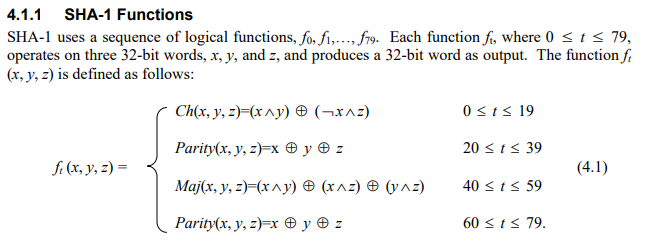

Reference: NIST FIPS PUB 180-4, Secure Hash Standard (SHS). See Section 2 (Binary and hexadecimal representations) and Section 4.1.2 (SHA-256 functions). Link: https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf

### Helper functions: 32-bit coercion, ROTR, SHR

We define small helpers to ensure everything stays in 32 bits and to implement rotation and logical shift as specified in the standard. These are used by the SHA-256 functions below.

In [14]:
# Cell 1: Imports and core type aliases
import numpy as np

# 32-bit unsigned word alias for clarity
U32 = np.uint32

def to_uint32(x) -> np.uint32:
    """Coerce x to a 32-bit unsigned integer (modulo 2**32).

    This ensures Python ints or other types are represented as 32-bit words.
    """
    return U32(int(x) & 0xFFFFFFFF)

In [15]:
def rotr(x: np.uint32, n: int) -> np.uint32:
    """Rotate the 32-bit word x right by n bits (ROTR^n(x)).

    Per FIPS 180-4, ROTR performs a circular right rotation.
    For n == 0, the result is x. Only the low 5 bits of n matter (n mod 32).
    """
    x = to_uint32(x)
    n = int(n) & 31
    if n == 0:
        return x
    # Perform rotation with 32-bit wrapping.
    right = x >> n
    left = to_uint32(x << (32 - n))
    return to_uint32(right | left)


def shr(x: np.uint32, n: int) -> np.uint32:
    """Logical right shift of the 32-bit word x by n bits (SHR^n(x)).

    This is a zero-fill right shift. Valid n is 0..31 inclusive.
    """
    x = to_uint32(x)
    n = int(n)
    if not (0 <= n <= 31):
        raise ValueError("SHR requires 0 <= n <= 31 for 32-bit words")
    return to_uint32(x >> n)

In [16]:
# Cell 3: Boolean mixing functions (used in hash constructions)

def parity(x: U32, y: U32, z: U32) -> U32:
    """Bitwise parity (XOR of x, y, z)."""
    return to_uint32(to_uint32(x) ^ to_uint32(y) ^ to_uint32(z))

def ch(x: U32, y: U32, z: U32) -> U32:
    """SHA-256 choose function: for each bit of x, choose from y if 1 else from z."""
    x, y, z = map(to_uint32, (x, y, z))
    return to_uint32((x & y) ^ (~x & z))

In [17]:
# Checks for helper functions
print("ROTR examples:")
print(f"rotr(0x80000000, 1) = {rotr(U32(0x80000000), 1):#010x} (expect 0x40000000)")
print(f"rotr(0x00000001, 1) = {rotr(U32(0x00000001), 1):#010x} (expect 0x80000000)")

print("\nSHR examples:")
print(f"shr(0x80000000, 1) = {shr(U32(0x80000000), 1):#010x} (expect 0x40000000)")
print(f"shr(0x00000001, 1) = {shr(U32(0x00000001), 1):#010x} (expect 0x00000000)")

ROTR examples:
rotr(0x80000000, 1) = 0x40000000 (expect 0x40000000)
rotr(0x00000001, 1) = 0x80000000 (expect 0x80000000)

SHR examples:
shr(0x80000000, 1) = 0x40000000 (expect 0x40000000)
shr(0x00000001, 1) = 0x00000000 (expect 0x00000000)


In [18]:

# Imports and 32-bit word setup
import numpy as np

# Alias for clarity: 32-bit unsigned integers
U32 = np.uint32

# Parity of three binary words
def Parity(x: np.uint32, y: np.uint32, z: np.uint32) -> np.uint32:
    """Compute the bitwise parity of three 32-bit words.

    Parity(x, y, z) = x XOR y XOR z, bitwise on 32-bit words.

    Each input is converted to a 32-bit unsigned integer using np.uint32.

    Parameters
    x, y, z : np.uint32
        32-bit words (numpy.uint32). 
        
    Returns
    np.uint32
        The 32-bit word resulting from x ^ y ^ z.
    """
    return to_uint32(to_uint32(x) ^ to_uint32(y) ^ to_uint32(z))


def Ch(x: np.uint32, y: np.uint32, z: np.uint32) -> np.uint32:
    """SHA-256 choose function.

    Ch(x, y, z) = (x AND y) XOR ((NOT x) AND z), bitwise on 32-bit words.
    For each bit of x, choose the corresponding bit from y if the bit
    in x is 1, else choose it from z.

    Reference: FIPS 180-4 §4.1.2
    """
    x, y, z = to_uint32(x), to_uint32(y), to_uint32(z)
    return to_uint32((x & y) ^ ((~x) & z))


def Maj(x: np.uint32, y: np.uint32, z: np.uint32) -> np.uint32:
    """SHA-256 majority function.

    Maj(x, y, z) = (x AND y) XOR (x AND z) XOR (y AND z), bitwise on 32-bit words.
    Intuition: for each bit position, returns the majority value among the bits
    of x, y, z at that position.

    Reference: FIPS 180-4 §4.1.2
    """
    x, y, z = to_uint32(x), to_uint32(y), to_uint32(z)
    return to_uint32((x & y) ^ (x & z) ^ (y & z))


def Sigma0(x: np.uint32) -> np.uint32:
    """Big Sigma 0 for SHA-256: Σ0(x) = ROTR^2(x) XOR ROTR^13(x) XOR ROTR^22(x).

    Reference: FIPS 180-4 §4.1.2
    """
    x = to_uint32(x)
    return to_uint32(rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22))


def Sigma1(x: np.uint32) -> np.uint32:
    """Big Sigma 1 for SHA-256: Σ1(x) = ROTR^6(x) XOR ROTR^11(x) XOR ROTR^25(x).

    Reference: FIPS 180-4 §4.1.2
    """
    x = to_uint32(x)
    return to_uint32(rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25))


def sigma0(x: np.uint32) -> np.uint32:
    """Small sigma 0 for SHA-256: σ0(x) = ROTR^7(x) XOR ROTR^18(x) XOR SHR^3(x).

    Reference: FIPS 180-4 §4.1.2
    """
    x = to_uint32(x)
    return to_uint32(rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3))


def sigma1(x: np.uint32) -> np.uint32:
    """Small sigma 1 for SHA-256: σ1(x) = ROTR^17(x) XOR ROTR^19(x) XOR SHR^10(x).

    Reference: FIPS 180-4 §4.1.2
    """
    x = to_uint32(x)
    return to_uint32(rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10))


## Tests for Problem 1 functions

In [ ]:
import numpy as np

def to_u32(v): return np.uint32(int(v) & 0xFFFFFFFF)

def rotr_ref(x, n):
    x = int(x) & 0xFFFFFFFF; n &= 31
    return to_u32(((x >> n) | ((x << (32 - n)) & 0xFFFFFFFF)))

def shr_ref(x, n):
    x = int(x) & 0xFFFFFFFF
    return to_u32(x >> n)

# Basic vectors
tests = [
    np.uint32(0x00000000),
    np.uint32(0xFFFFFFFF),
    np.uint32(0x12345678),
    np.uint32(0x80000000),
    np.uint32(0x00000001),
]

# Parity / Ch / Maj
x, y, z = np.uint32(0x12345678), np.uint32(0x9abcdef0), np.uint32(0x0fedcba9)
assert Parity(x,y,z) == to_u32(int(x) ^ int(y) ^ int(z))
assert Ch(x,y,z)     == to_u32((int(x) & int(y)) ^ ((~int(x)) & int(z)))
assert Maj(x,y,z)    == to_u32((int(x) & int(y)) ^ (int(x) & int(z)) ^ (int(y) & int(z)))

# Edge cases for Ch
assert Ch(np.uint32(0xFFFFFFFF), y, z) == y
assert Ch(np.uint32(0x00000000), y, z) == z

# Σ0, Σ1, σ0, σ1 vs reference bit-twiddling
for t in tests:
    assert Sigma0(t) == to_u32(rotr_ref(t,2) ^ rotr_ref(t,13) ^ rotr_ref(t,22))
    assert Sigma1(t) == to_u32(rotr_ref(t,6) ^ rotr_ref(t,11) ^ rotr_ref(t,25))
    assert sigma0(t) == to_u32(rotr_ref(t,7) ^ rotr_ref(t,18) ^ shr_ref(t,3))
    assert sigma1(t) == to_u32(rotr_ref(t,17) ^ rotr_ref(t,19) ^ shr_ref(t,10))

print("All Problem 1 tests passed.")

All Problem 1 tests passed.


## Problem 2: Fractional Parts of Cube Roots

## Problem 3: Padding

## Problem 4: Hashes

## Problem 5: Passwords

# End